# AEOLUS API queries

- Sample SQL queries for building AEOLUS/ Nsides API
- Demo of pulling cumulative results for amiodarone and generating plots

In [1]:
%matplotlib inline

In [2]:
import MySQLdb
from collections import defaultdict
from tqdm import tqdm
import numpy as np
from scipy import stats
import csv

import cPickle as pickle

import matplotlib.pyplot as plt
import seaborn as sns

ImportError: No module named MySQLdb

In [3]:
con = MySQLdb.connect(read_default_file='~/.my.cnf', db = 'effect_faers')
cur = con.cursor()

In [4]:
qt_outcomes = ('TORSADE DE POINTES',
               'ELECTROCARDIOGRAM QT CORRECTED INTERVAL PROLONGED',
               'ELECTROCARDIOGRAM QT PROLONGED',
               'LONG QT SYNDROME',
               'LONG QT SYNDROME CONGENITAL')

drug1 = ('AMIODARONE', 'CORDARONE') #('METHADONE', 'METHADOSE', 'DOLOPHINE') #('LANSOPRAZOLE', 'PREVACID') # ('METHADONE', 'METHADOSE', 'DOLOPHINE')
# drug2 = ('QUETIAPINE', 'SEROQUEL') #('CEFTRIAXONE', 'ROCEPHIN')

In [8]:
# reports on drugs per year
years = range(2004,2016)

yr2reports_on_drug = defaultdict(list)

for year in years:
    print year,
    SQL = '''select distinct isr_report_id
            from effect_faers.drugs c
            where drug_name in %s
            and report_year = %d;''' %(drug1, year)
    cur.execute(SQL)
    results = cur.fetchall()
    
    for result in results:
        report_id = result[0]
        yr2reports_on_drug[year].append(int(report_id))
        
    print len(yr2reports_on_drug[year])

2004 987
2005 1330
2006 911
2007 857
2008 849
2009 1352
2010 1603
2011 1761
2012 1655
2013 2502
2014 2848
2015 1106


In [9]:
# reports not on drug per year
yr2reports_not_on_drug = defaultdict(list)

for year in years:
    print year,
    
    SQL = '''select distinct isr_report_id
            from effect_faers.drugs
            where report_year = %d;''' %year
    cur.execute(SQL)
    results = cur.fetchall()
    
    for result in results:
        report_id = int(result[0])
        if report_id not in yr2reports_on_drug[year]:
            yr2reports_not_on_drug[year].append(report_id)
        
    print len(yr2reports_not_on_drug[year])

2004 271308
2005 324344
2006 322880
2007 377318
2008 440163
2009 489955
2010 671572
2011 781039
2012 830496
2013 810821
2014 900936
2015 316067


In [26]:
# Calculate PRR and 95% CI (cumulative)
yr2ci_cumulative = dict()
yr2prr_cumulative = dict()
yr2a_cumulative = dict()

a  = 0 # a: on drugs with ADR
ab = 0 # a+b: on drugs

c  = 0 # c: not on drugs with ADR
cd = 0 # c+d: not on drugs
for year in years:
    print '\n',year,
    
    a_yr = 0
    c_yr = 0
    
    SQL =  '''select distinct isr_report_id
            from effect_faers.reactions
            where event_descrip_term in %s
            and report_year = %d;''' %(qt_outcomes, year)
    cur.execute(SQL)
    results = cur.fetchall()
    
    for result in results:
        report_id = int(result[0])
        
        if report_id in yr2reports_on_drug[year]:
            a_yr += 1
        else:
            c_yr += 1

    ab_yr = len(yr2reports_on_drug[year])
    cd_yr = len(yr2reports_not_on_drug[year])
    
    
    a  += a_yr
    ab += ab_yr
    c  += c_yr
    cd += cd_yr
    
    print a,ab,c,cd
    yr2a_cumulative[year] = a
    
    prr = (float(a)/ab)/(float(c)/cd)
    print " PRR = ",prr

    s = np.sqrt( 1.0/a + 1.0/c - 1.0/ab - 1.0/cd )
    print "   s = ",s
    
    yr2prr_cumulative[year] = prr
    yr2ci_cumulative[year] = (prr/np.exp(1.96*s), prr*np.exp(1.96*s))
    
    print "95%%CI: (%.2f, %.2f)" %(prr/np.exp(1.96*s), prr*np.exp(1.96*s))


2004 26 987 1206 271308
 PRR =  5.92613427291
   s =  0.195637084379
95%CI: (4.04, 8.70)

2005 67 2317 2347 595652
 PRR =  7.33885460442
   s =  0.122139991676
95%CI: (5.78, 9.32)

2006 118 3228 3320 918532
 PRR =  10.1135747451
   s =  0.0920049077687
95%CI: (8.44, 12.11)

2007 145 4085 4321 1295850
 PRR =  10.6450181956
   s =  0.0829602910944
95%CI: (9.05, 12.52)

2008 165 4934 5583 1736013
 PRR =  10.3984867854
   s =  0.0776947223752
95%CI: (8.93, 12.11)

2009 201 6286 7175 2225968
 PRR =  9.92016034748
   s =  0.0703915071556
95%CI: (8.64, 11.39)

2010 271 7889 8924 2897540
 PRR =  11.1536551612
   s =  0.0606216988821
95%CI: (9.90, 12.56)

2011 311 9650 10795 3678579
 PRR =  10.9822295296
   s =  0.0566053952895
95%CI: (9.83, 12.27)

2012 359 11305 12731 4509075
 PRR =  11.2473140764
   s =  0.0526819279759
95%CI: (10.14, 12.47)

2013 396 13807 14176 5319896
 PRR =  10.7632963683
   s =  0.0502312580233
95%CI: (9.75, 11.88)

2014 470 16655 15806 6220832
 PRR =  11.106563814
   

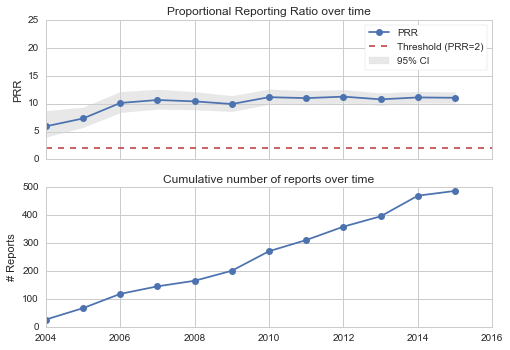

In [27]:
# Plot cumulative
sns.set_style("whitegrid")

ax1 = plt.subplot(2, 1, 1) # PRR over time
plt.fill_between(years, [yr2ci_cumulative[year][0] for year in years], [yr2ci_cumulative[year][1] for year in years],color='lightgrey',alpha=0.5, label='95% CI')

plt.plot(years, [yr2prr_cumulative[year] for year in years], 'o-', label='PRR')

plt.axhline(y=2, linestyle='--', color='#C44E52', label='Threshold (PRR=2)')
plt.legend(frameon=True)
plt.ylim(0,25)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.ylabel('PRR')
plt.title('Proportional Reporting Ratio over time')

ax2 = plt.subplot(2, 1, 2) # num_reports over time
plt.plot(years, [yr2a_cumulative[year] for year in years], 'o-')
plt.ylabel('# Reports')
plt.title('Cumulative number of reports over time')

plt.savefig('amiodarone_lqts_timelines_cumulative.pdf')

In [28]:
# Save to csv - cumulative
outf = open('amiodarone_lqts_timelines_cumulative.csv', 'w')
writer = csv.writer(outf)
writer.writerow(['year', 'PRR', 'CI_lower', 'CI_upper', 'num_reports'])
for year in years:
    writer.writerow([year, '%.2f' %yr2prr_cumulative[year], '%.2f' %yr2ci_cumulative[year][0], '%.2f' %yr2ci_cumulative[year][1], yr2a_cumulative[year]])
outf.close()

In [30]:
cur.close()
con.close()